In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model/RF_21122024_models_ultraF \
/media/concha-eloko/Linux/PPT_clean/reviewed_models



In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter, defaultdict
import warnings
import logging
import subprocess
from multiprocessing.pool import ThreadPool
import joblib

# SCikitlearn modules :
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report , roc_auc_score, matthews_corrcoef
from sklearn.metrics import roc_auc_score

# Scipy modules : 
from scipy.stats import fisher_exact
from statistics import mean


PATH_WORK = "/media/concha-eloko/Linux/PPT_clean"
path_metrics = f"{PATH_WORK}/metric_files"

### Make the metrics files : 

In [4]:
def load_data():
    df_info = pd.read_csv(f"{PATH_WORK}/TropiGATv2.final_df_v2.tsv", sep="\t", header=0)
    df_prophages = df_info.drop_duplicates(subset=["Phage"], keep="first")
    dico_prophage_info = {row["Phage"]: {"prophage_strain": row["prophage_id"], "ancestor": row["Infected_ancestor"]} for _, row in df_prophages.iterrows()}
    return df_info, dico_prophage_info


def get_filtered_prophages(prophage, df_info, dico_prophage_info):
    to_exclude = set()
    to_keep = {prophage}
    df_prophage_group = df_info[(df_info["prophage_id"] == dico_prophage_info[prophage]["prophage_strain"]) & 
                                (df_info["Infected_ancestor"] == dico_prophage_info[prophage]["ancestor"])]
    
    if len(df_prophage_group) > 1:
        depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage]["domain_seq"].values)
        combinations = [depo_set]
        
        for prophage_tmp in df_prophage_group["Phage"].unique():
            if prophage_tmp != prophage:
                tmp_depo_set = set(df_prophage_group[df_prophage_group["Phage"] == prophage_tmp]["domain_seq"].values)
                if tmp_depo_set in combinations:
                    to_exclude.add(prophage_tmp)
                else:
                    to_keep.add(prophage_tmp)
                    combinations.append(tmp_depo_set)
    
    return df_prophage_group, to_exclude, to_keep

def filter_prophages(df_info, dico_prophage_info):
    good_prophages = set()
    excluded_prophages = set()
    for prophage in tqdm(dico_prophage_info.keys()):
        if prophage not in excluded_prophages and prophage not in good_prophages:
            _, excluded_members, kept_members = get_filtered_prophages(prophage, df_info, dico_prophage_info)
            good_prophages.update(kept_members)
            excluded_prophages.update(excluded_members)
    df_info_filtered = df_info[df_info["Phage"].isin(good_prophages)]
    return df_info_filtered[~df_info_filtered["KL_type_LCA"].str.contains("\\|")]

def ultrafilter_prophages(df_info):
    duplicate_prophage = []
    for kltype in df_info["KL_type_LCA"].unique():
        df_kl = df_info[df_info["KL_type_LCA"] == kltype][["Phage", "domain_seq"]]
        set_sets_depo = []
        for _, group in df_kl.groupby("Phage"):
            set_depo = frozenset(group["domain_seq"].values)
            if set_depo in set_sets_depo:
                duplicate_prophage.extend(group["Phage"])
            else:
                set_sets_depo.append(set_depo)
    
    return df_info[~df_info["Phage"].isin(duplicate_prophage)]


def get_mean_MCC(path_data_object):
    try:
        assert os.path.isfile(path_data_object)
        data_object = joblib.load(path_data_object)
        mcc_values = []
        for i in data_object:
            y_test = data_object[i]["test_data"][0].values
            predictions = data_object[i]["test_data"][1]
            mcc = matthews_corrcoef(y_test, predictions)
            mcc_values.append(mcc)
        del data_object 
        mean_mcc = mean(mcc_values)
        return mean_mcc
    except AssertionError:
        raise FileNotFoundError(f"File not found: {path_data_object}")
        


> TropiSEQ (unique depolymerase sets)

In [5]:
path_jobs = f"{PATH_WORK}/reviewed_models/RF_21122024_models_ultraF"

cluster_values = set([file.split("_")[0] for file in os.listdir(path_jobs)])
KLtypes = set([file.split("_RF_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_RF_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}

DF_info, dico_prophage_info = load_data()
# UF or not ?
DF_info_lvl_0 = ultrafilter_prophages(filter_prophages(DF_info, dico_prophage_info))
#DF_info_lvl_0 = filter_prophages(DF_info, dico_prophage_info)

dico_prophage_count = Counter(DF_info_lvl_0["KL_type_LCA"])



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15981/15981 [00:17<00:00, 915.29it/s]


In [19]:
dico_prophage_count

Counter({'KL64': 316,
         'KL25': 233,
         'KL107': 223,
         'KL17': 223,
         'KL24': 179,
         'KL23': 170,
         'KL47': 158,
         'KL2': 151,
         'KL106': 150,
         'KL28': 150,
         'KL3': 147,
         'KL60': 138,
         'KL14': 130,
         'KL102': 128,
         'KL62': 124,
         'KL27': 119,
         'KL15': 107,
         'KL74': 100,
         'KL46': 90,
         'KL10': 83,
         'KL111': 82,
         'KL38': 78,
         'KL30': 77,
         'KL13': 76,
         'KL19': 70,
         'KL110': 65,
         'KL105': 65,
         'KL1': 61,
         'KL45': 57,
         'KL12': 57,
         'KL29': 56,
         'KL43': 55,
         'KL63': 55,
         'KL57': 54,
         'KL21': 53,
         'KL149': 51,
         'KL22': 50,
         'KL81': 49,
         'KL70': 49,
         'KL127': 49,
         'KL145': 48,
         'KL36': 48,
         'KL53': 48,
         'KL123': 46,
         'KL51': 41,
         'KL7': 39,
         '

In [16]:
def get_mean_MCC(path_data_object):
    try:
        assert os.path.isfile(path_data_object)
        data_object = joblib.load(path_data_object)
        mcc_values = []
        for i in data_object:
            y_test = data_object[i]["test_data"][0].values
            predictions = data_object[i]["test_data"][1]
            mcc = matthews_corrcoef(y_test, predictions)
            mcc_values.append(mcc)
        del data_object 
        mean_mcc = mean(mcc_values)
        return mean_mcc
    except AssertionError:
        raise FileNotFoundError(f"File not found: {path_data_object}")

"""with open(f"{PATH_WORK}/SEQ_based.RF__UF.prophages_metrics.tsv", "w") as outfile :
    for KLtype in tqdm(KLtypes_paths) : 
        for path in KLtypes_paths[KLtype] :
            cl_value = path.split("/")[-1].split("_RF")[0]
            mean_mcc = get_mean_MCC(path)
            count_kltype = dico_prophage_count[KLtype]
            outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")"""

with open(f"{PATH_WORK}/SEQ_based.RF__UF.prophages_metrics.review.tsv", "w") as outfile :
    for file in tqdm(os.listdir("/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model/reviewed_models/TropiSEQ_UF")) : 
        KLtype = file.split("RF_")[1].split(".")[0]
        path = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model/reviewed_models/TropiSEQ_UF/" + file
        cl_value = path.split("/")[-1].split("_RF")[0]
        mean_mcc = get_mean_MCC(path)
        count_kltype = dico_prophage_count[KLtype]
        outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:38<00:00,  2.81it/s]


In [11]:
metric_rf_uf = pd.read_csv(f"{PATH_WORK}/SEQ_based.RF__UF.prophages_metrics.review.tsv", sep = "\t", names = ["KL_type", "n_prophages", "c_value", "MCC"])
metric_rf_uf = metric_rf_uf.sort_values(by="KL_type", 
                                        key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))
metric_rf_uf.to_csv(f"{PATH_WORK}/SEQ_based.RF__UF.prophages_metrics.sorted.review.tsv", sep = "\t", index = False, header = True)

> TropiSEQ (single infectious events)

In [ ]:
path_jobs = f"{PATH_WORK}/RF_1302_models"

cluster_values = set([file.split("_")[0] for file in os.listdir(path_jobs)])
KLtypes = set([file.split("_RF_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_RF_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}

DF_info, dico_prophage_info = load_data()
# UF or not ?
#DF_info_lvl_0 = ultrafilter_prophages(filter_prophages(DF_info, dico_prophage_info))
DF_info_lvl_0 = filter_prophages(DF_info, dico_prophage_info)

dico_prophage_count = Counter(DF_info_lvl_0["KL_type_LCA"])

with open(f"{path_metrics}/SEQ_based.RF.prophages_metrics.tsv", "w") as outfile :
    for KLtype in tqdm(KLtypes_paths) : 
        for path in KLtypes_paths[KLtype] :
            cl_value = path.split("/")[-1].split("_RF")[0]
            mean_mcc = get_mean_MCC(path)
            count_kltype = dico_prophage_count[KLtype]
            outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")


> Logistic regression (single infectious events)

In [ ]:
path_jobs = f"{PATH_WORK}/LR_21122024_models"

cluster_values = set([file.split("_")[0] for file in os.listdir(path_jobs)])
KLtypes = set([file.split("_LogReg_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_LogReg_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}

DF_info, dico_prophage_info = load_data()
# UF or not ?
#DF_info_lvl_0 = ultrafilter_prophages(filter_prophages(DF_info, dico_prophage_info))
DF_info_lvl_0 = filter_prophages(DF_info, dico_prophage_info)

dico_prophage_count = Counter(DF_info_lvl_0["KL_type_LCA"])

with open(f"{path_metrics}/SEQ_based.LogReg.prophages_metrics.tsv", "w") as outfile :
    for KLtype in tqdm(KLtypes_paths) : 
        for path in KLtypes_paths[KLtype] :
            cl_value = path.split("/")[-1].split("_RF")[0]
            mean_mcc = get_mean_MCC(path)
            count_kltype = dico_prophage_count[KLtype]
            outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")

> Logistic regressino (unique depolymerase sets)

In [ ]:
path_jobs = f"{PATH_WORK}/LR_21122024_models_ultraF"

cluster_values = set([file.split("_")[0] for file in os.listdir(path_jobs)])
KLtypes = set([file.split("_LogReg_")[1].split(".full_data")[0] for file in os.listdir(path_jobs)])

KLtypes_paths = {kltype : [f"{path_jobs}/{file}" for file in os.listdir(path_jobs) if file.split("_LogReg_")[1].split(".full_data")[0]==kltype]
                for kltype in KLtypes}

DF_info, dico_prophage_info = load_data()
# UF or not ?
DF_info_lvl_0 = ultrafilter_prophages(filter_prophages(DF_info, dico_prophage_info))
#DF_info_lvl_0 = filter_prophages(DF_info, dico_prophage_info)

dico_prophage_count = Counter(DF_info_lvl_0["KL_type_LCA"])

with open(f"{path_metrics}/SEQ_based.LogReg__UF.prophages_metrics.tsv", "w") as outfile :
    for KLtype in tqdm(KLtypes_paths) : 
        for path in KLtypes_paths[KLtype] :
            cl_value = path.split("/")[-1].split("_RF")[0]
            mean_mcc = get_mean_MCC(path)
            count_kltype = dico_prophage_count[KLtype]
            outfile.write(f"{KLtype}\t{count_kltype}\t{cl_value}\t{mean_mcc}\n")

***
### Compute the weighted MCC:

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model/metric_files \
/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model


In [5]:
path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model/metric_files"

threshold = 5
names_metric_col = ["KL_type", "Count", "file_name","mean_mcc"]
final_weighted_dico = {}

for file in os.listdir(path_metrics):
    metric_df = pd.read_csv(f"{path_metrics}/{file}", sep = "\t", names = names_metric_col)
    metric_eval_df = metric_df[metric_df["Count"] > threshold]
    metric_eval_df["c_value"] = metric_eval_df["file_name"].astype(str).apply(lambda x: x.split("_")[0])
    weighted_mcc_dico = {}
    for cluster in metric_eval_df["c_value"].unique().tolist() :
        mcc_sum = 0
        cl_df = metric_eval_df[metric_eval_df["c_value"] == cluster]
        for _,row in cl_df.iterrows() : 
            mcc_sum = mcc_sum + row["mean_mcc"] * row["Count"]
        weighted_mcc = mcc_sum / (sum(cl_df["Count"]))
        weighted_mcc_dico[cluster] = weighted_mcc
    final_weighted_dico[file] = weighted_mcc_dico



/tmp/ipykernel_2965761/2213569197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_eval_df["c_value"] = metric_eval_df["file_name"].astype(str).apply(lambda x: x.split("_")[0])
/tmp/ipykernel_2965761/2213569197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_eval_df["c_value"] = metric_eval_df["file_name"].astype(str).apply(lambda x: x.split("_")[0])
/tmp/ipykernel_2965761/2213569197.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [6]:
final_weighted_dico

{'SEQ_based.LogReg__UF.prophages_metrics.tsv': {'0.85': 0.3151602636210511,
  '0.9': 0.32933361394227706,
  '0.8': 0.34091186979267774,
  '0.7': 0.36446002765094077,
  '0.95': 0.27893023121060845,
  '0.75': 0.3463067872443405,
  '0.65': 0.36193177410601585,
  '0.975': 0.25498957852463594},
 'SEQ_based.LogReg.prophages_metrics.tsv': {'0.85': 0.3722464784487348,
  '0.9': 0.33694270698415413,
  '0.8': 0.3659430012749742,
  '0.7': 0.36964008602380943,
  '0.95': 0.3319429903096709,
  '0.75': 0.374760037337778,
  '0.65': 0.39023597272237615,
  '0.975': 0.27913217655865474},
 'SEQ_based.RF.prophages_metrics.tsv': {'0.95': 0.7505887697037068,
  '0.9': 0.7665851018307361,
  '0.85': 0.7677152879518742,
  '0.75': 0.7576805724196833,
  '0.975': 0.7326524783190056,
  '0.8': 0.7651531836408012,
  '0.7': 0.7564513341443188,
  '0.65': 0.7666988914668954},
 'SEQ_based.RF__UF.prophages_metrics.tsv': {'0.95': 0.3093359009354269,
  '0.8': 0.3427715092677616,
  '0.7': 0.3590017290690273,
  '0.85': 0.351137

In [ ]:
SEQ_based.LogReg__UF.prophages_metrics.tsv : '0.7': 0.36446002765094077
SEQ_based.LogReg.prophages_metrics.tsv : '0.65': 0.39023597272237615 

SEQ_based.RF.prophages_metrics.tsv : '0.85': 0.7677152879518742
SEQ_based.RF__UF.prophages_metrics.tsv : '0.65': 0.3669266262836219

In [ ]:
import os 

path_work = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model"

dico_models = {"LR_21122024_models" : {"c_value" : "0.65", "destination" : "LogReg"}, 
               #"LR_21122024_models_ultraF" : {"c_value" : "0.7", "destination" : "LogReg_UF"} , 
               #"RF_21122024_models_ultraF" : {"c_value" : "0.65", "destination" : "TropiSEQ_UF"},
               "RF_21122024_models_ultraF" : {"c_value" : "0.7", "destination" : "TropiSEQ_UF_70"},
               #"RF_21122024_models_ultraF" : {"c_value" : "0.85", "destination" : "TropiSEQ_UF_85"},
              }

os.makedirs(f"{path_work}/reviewed_models/TropiSEQ_UF_70", exist_ok=True)

for file in os.listdir(path_work) : 
    if file in dico_models : 
        if file == "RF_21122024_models_ultraF":
            for model in os.listdir(f"{path_work}/{file}") :
                if model.startswith(dico_models[file]["c_value"]) :
                    os.system(f"cp {path_work}/{file}/{model} {path_work}/reviewed_models/{dico_models[file]['destination']}")

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model/reviewed_models \
/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model


***
### Write the Metrics file: 

In [7]:
import os 
import pandas as pd
import json 

path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/review_work/SeqBased_model/metric_files"

df_rf_uf = pd.read_csv(f"{path_metrics}/SEQ_based.RF__UF.prophages_metrics.tsv", sep = "\t", names = ["KL_types", "number_prophages", "c_value", "MCC"])
df_rf_uf = df_rf_uf[df_rf_uf["c_value"] == 0.65]

In [ ]:
path_seqbased = "/media/concha-eloko/Linux/PPT_clean/Seqbased_model"

dico_cluster = json.load(open(f"{path_seqbased}/dico_cluster.cdhit__0.65.json"))
dico_cluster_r = {ref_dpo : key_dpo for key_dpo,list_dpo in dico_cluster.items() for ref_dpo in list_dpo}

> DataFrame :

In [ ]:
from tqdm import tqdm

path_work = "/media/concha-eloko/Linux/PPT_clean"

df_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.tsv", sep = "\t" ,  header = 0)
df_prophages = df_info.drop_duplicates(subset = ["Phage"], keep = "first")
dico_prophage_info = {row["Phage"] : {"prophage_strain" : row["prophage_id"] , "ancestor" : row["Infected_ancestor"]} for _,row in df_prophages.iterrows()}

df_info_final = ultrafilter_prophages(filter_prophages(df_info, dico_prophage_info))
df_info_final["dpo_cluster"] = df_info_final["index"].apply(lambda x : dico_cluster_r[x])

In [ ]:
def get_number_dpocluster(df, kltype) :
    relevant_df = df[df["KL_type_LCA"] == kltype]
    n_cluster = relevant_df["dpo_cluster"].unique()
    return len(n_cluster)

In [ ]:
get_number_dpocluster(df_info_final, "KL24")

In [ ]:
for _, row in df_rf_uf.iterrows() :
    n_clusters = get_number_dpocluster(df_info_final, row["KL_types"])
    ratio = n_clusters / row["number_prophages"]
    print(row["KL_types"], round(row["MCC"], 3), round(ratio, 3), n_clusters , row["number_prophages"], sep = "\t")

In [ ]:
df_rf_uf

***
# Plot MCC scores: 

In [21]:
import os 
import pandas as pd
import json 

path_metrics = "/media/concha-eloko/Linux/PPT_clean"

#df_rf_uf = pd.read_csv(f"{path_metrics}/SEQ_based.RF__UF.prophages_metrics.review.tsv", sep = "\t", names = ["KL_types", "number_prophages", "c_value", "MCC"])
df_rf_uf = pd.read_csv(f"{path_metrics}/KLtype_metrics.TropiSEQ.review.tsv", sep = "\t", names = ["KL_types", "number_prophages", "c_value", "MCC"])

df_rf_uf = df_rf_uf[df_rf_uf["c_value"] == 0.65]


In [22]:
df_rf_uf

,KL_types,number_prophages,c_value,MCC
0,KL36,48,0.65,0.323017
1,KL125,30,0.65,0.000000
2,KL6,12,0.65,0.000000
3,KL7,39,0.65,0.573359
4,KL12,57,0.65,0.604520
...,...,...,...,...
103,KL82,7,0.65,0.160000
104,KL149,51,0.65,0.302048
105,KL107,223,0.65,0.353817
106,KL31,14,0.65,0.000000


In [5]:
data = list(zip(df_rf_uf["MCC"].tolist(), df_rf_uf["number_prophages"].tolist()))
data_scatter_tropiseq = pd.DataFrame(data, columns=["MCC", "n_prophages"])

data_scatter_tropiseq

,MCC,n_prophages
0,0.323017,48
1,0.000000,30
2,0.000000,12
3,0.573359,39
4,0.604520,57
...,...,...
103,0.160000,7
104,0.302048,51
105,0.353817,223
106,0.000000,14


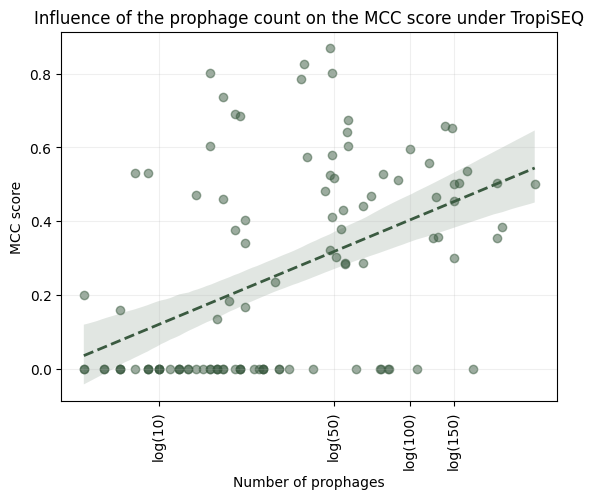

Pearson's r: 0.46159456442729746
P-value: 4.952840626567285e-07


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr  # Import for Pearson correlation

path_panels = "/media/concha-eloko/Linux/papers/PPT/reviewed_new_figures/panels"

df = pd.DataFrame(data_scatter_tropiseq, columns=['n_prophages', 'MCC'])
df['log_Number of prophages'] = np.log(df['n_prophages'])

# Calculate Pearson correlation
correlation, p_value = pearsonr(df['log_Number of prophages'], df['MCC'])

# Draw the regression plot
ax = sns.regplot(x="log_Number of prophages", y="MCC", data=df, color="#3A5A40", scatter_kws={'alpha': 0.5}, line_kws={'linewidth': 2, 'linestyle': '--'})

# Add correlation and p-value to the plot (uncommented and modified)
correlation_str = f"Pearson's r = {correlation:.2f}"
p_value_str = f"p-value = {p_value:.3f}"


#ax.text(0.05, 0.9, equation, transform=ax.transAxes, fontsize=10, color="black")
#ax.text(0.05, 0.85, r_squared, transform=ax.transAxes, fontsize=10, color="black")
#ax.text(0.05, 0.8, p_value_str, transform=ax.transAxes, fontsize=10, color="black")

# Set the desired x-axis ticks and labels
desired_ticks = [np.log(10), np.log(50), np.log(100), np.log(150)]
desired_labels = ["log(10)", "log(50)", "log(100)", "log(150)"]

plt.xticks(desired_ticks, desired_labels, rotation=90)  # Set ticks and labels

plt.grid(True, alpha=0.2, linestyle='-')

plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Influence of the prophage count on the MCC score under TropiSEQ')

plt.savefig(f'{path_panels}/scatter_plot.TropiSeq.review.svg',format = "svg", transparent = True)  # You can change the file extension as needed

plt.show()


print(f"Pearson's r: {correlation}")
print(f"P-value: {p_value}")

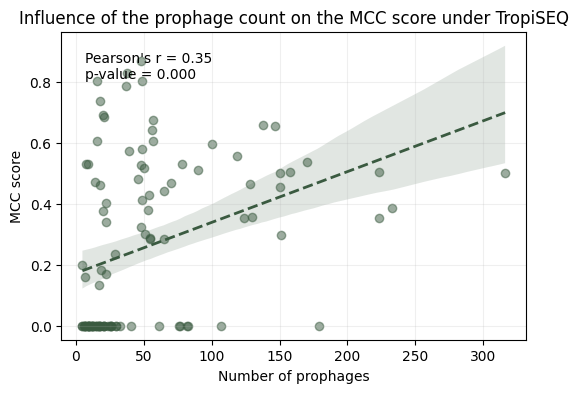

Pearson's r: 0.35461858378247274
P-value: 0.0001661742250571669


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

path_panels = "/media/concha-eloko/Linux/papers/PPT/reviewed_new_figures/panels"

df = pd.DataFrame(data_scatter_tropiseq, columns=['n_prophages', 'MCC'])
plt.figure(figsize=(6, 4)) 

# Calculate Pearson correlation (using the original n_prophages)
correlation, p_value = pearsonr(df['n_prophages'], df['MCC'])

# Draw the regression plot (using the original n_prophages)
ax = sns.regplot(x="n_prophages", y="MCC", data=df, color="#3A5A40", scatter_kws={'alpha': 0.5}, line_kws={'linewidth': 2, 'linestyle': '--'})

# Add correlation and p-value to the plot
correlation_str = f"Pearson's r = {correlation:.2f}"
p_value_str = f"p-value = {p_value:.3f}"

ax.text(0.05, 0.9, correlation_str, transform=ax.transAxes, fontsize=10, color="black")
ax.text(0.05, 0.85, p_value_str, transform=ax.transAxes, fontsize=10, color="black")

# Set the desired x-axis ticks and labels (using original values, but you can customize)
# If you want to show actual values on the x-axis rather than log, you don't need log here
# However, if the values are too large or too small, the plot might be unreadable.
# You can customize the ticks and labels, for example, by choosing a subset of values.

# Example of setting ticks at specific values
# desired_ticks = [10, 50, 100, 150]  # Example: Set ticks at 10, 50, 100, 150
# plt.xticks(desired_ticks, [str(tick) for tick in desired_ticks], rotation=90) # Convert to strings

plt.grid(True, alpha=0.2, linestyle='-')

plt.xlabel('Number of prophages')
plt.ylabel('MCC score')
plt.title('Influence of the prophage count on the MCC score under TropiSEQ')

plt.savefig(f'{path_panels}/scatter_plot.TropiSeq.review_nolog.svg', format="svg", transparent=True)

plt.show()

print(f"Pearson's r: {correlation}")
print(f"P-value: {p_value}")